In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torchvision.models import mobilenet_v2

from sklearn.metrics import confusion_matrix

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [ ]:
transform_pretrained = transforms.Compose([
    transforms.Resize((224, 224)),           
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) 
])

dataset = torchvision.datasets.ImageFolder(root=r'art500k_period', transform=transform_pretrained)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
trainset_pretrained, testset_pretrained = torch.utils.data.random_split(dataset, [train_size, test_size])

trainloader_pretrained = torch.utils.data.DataLoader(trainset_pretrained, batch_size=32,
                                                     shuffle=True, num_workers=16)
testloader_pretrained = torch.utils.data.DataLoader(testset_pretrained, batch_size=32,
                                                    shuffle=False, num_workers=16)

print("Pre-trained model data loaded: train size =", len(trainset_pretrained),
      ", test size =", len(testset_pretrained))

Pre-trained model data loaded: train size = 38424 , test size = 9606


In [ ]:
mobilenet = mobilenet_v2(pretrained=True)

for param in mobilenet.features.parameters():
    param.requires_grad = False

num_features = mobilenet.last_channel 
mobilenet.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(num_features, 5)
)

class PretrainedMobileNetV2(torch.nn.Module):
    def __init__(self, base_model):
        super(PretrainedMobileNetV2, self).__init__()
        self.base_model = base_model
        
    def forward(self, x):
        x = self.base_model.features(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        embedding = x  
        logits = self.base_model.classifier(embedding)
        return logits, embedding

/share/u/jessica/.conda/envs/ml/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/share/u/jessica/.conda/envs/ml/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
pretrained_model = PretrainedMobileNetV2(mobilenet).to(device)

criterion_pretrained = nn.CrossEntropyLoss()
optimizer_pretrained = optim.Adam(filter(lambda p: p.requires_grad, pretrained_model.parameters()), lr=0.00001)

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []


num_epochs_pretrained = 50
print("Training the pre‑trained (frozen base) model...")
for epoch in range(num_epochs_pretrained):
    epoch_start = time.time()
    
    # training
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in trainloader_pretrained:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_pretrained.zero_grad()
        outputs, _ = pretrained_model(inputs)
        loss = criterion_pretrained(outputs, labels)
        loss.backward()
        optimizer_pretrained.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    epoch_train_loss = train_loss / len(trainset_pretrained)
    train_accuracy = 100 * correct_train / total_train

    # evaluation on test set
    pretrained_model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in testloader_pretrained:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = pretrained_model(inputs)
            loss = criterion_pretrained(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
    epoch_test_loss = test_loss / len(testset_pretrained)
    test_accuracy = 100 * correct_test / total_test
    
    epoch_time = time.time() - epoch_start
    
    print(f"Epoch [{epoch+1}/{num_epochs_pretrained}] -- "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Test Loss: {epoch_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%, "
          f"Time: {epoch_time:.2f} sec")
    train_loss_list.append(epoch_train_loss)
    train_acc_list.append(train_accuracy)
    test_loss_list.append(epoch_test_loss)
    test_acc_list.append(test_accuracy)
    
    pretrained_model.train()

print("Finished training the pre‑trained (frozen) model.")

Training the pre‑trained (frozen base) model...
Epoch [1/50] -- Train Loss: 1.4586, Train Acc: 38.78%, Test Loss: 1.3954, Test Acc: 42.16%, Time: 57.12 sec
Epoch [2/50] -- Train Loss: 1.3731, Train Acc: 43.54%, Test Loss: 1.3318, Test Acc: 45.95%, Time: 55.46 sec
Epoch [3/50] -- Train Loss: 1.3227, Train Acc: 45.95%, Test Loss: 1.2888, Test Acc: 47.40%, Time: 55.17 sec
Epoch [4/50] -- Train Loss: 1.2888, Train Acc: 47.23%, Test Loss: 1.2603, Test Acc: 48.55%, Time: 54.50 sec
Epoch [5/50] -- Train Loss: 1.2634, Train Acc: 48.28%, Test Loss: 1.2350, Test Acc: 49.46%, Time: 54.80 sec
Epoch [6/50] -- Train Loss: 1.2462, Train Acc: 48.91%, Test Loss: 1.2169, Test Acc: 50.59%, Time: 54.82 sec
Epoch [7/50] -- Train Loss: 1.2272, Train Acc: 49.53%, Test Loss: 1.2017, Test Acc: 50.60%, Time: 54.71 sec
Epoch [8/50] -- Train Loss: 1.2136, Train Acc: 50.36%, Test Loss: 1.1878, Test Acc: 51.47%, Time: 55.10 sec
Epoch [9/50] -- Train Loss: 1.2043, Train Acc: 50.77%, Test Loss: 1.1768, Test Acc: 52.3

In [ ]:
# evaluate on the test set and extract embeddings

pretrained_model.eval()
correct = 0
total = 0
all_embeddings_pretrained = []
all_labels_pretrained = []
all_true = []
all_preds = []

with torch.no_grad():
    for inputs, labels in testloader_pretrained:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, embeddings = pretrained_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_true.extend(labels.cpu().numpy())
        if len(all_embeddings_pretrained) < 500:
            all_embeddings_pretrained.append(embeddings.cpu())
            all_labels_pretrained.append(labels.cpu())

accuracy_pretrained = 100 * correct / total
print(f"Pre‑trained (frozen) model Test Accuracy: {accuracy_pretrained:.2f}%")

embeddings_pretrained_frozen = torch.cat(all_embeddings_pretrained, dim=0)[:500]
labels_pretrained = torch.cat(all_labels_pretrained, dim=0)[:500]

Pre‑trained (frozen) model Test Accuracy: 57.11%


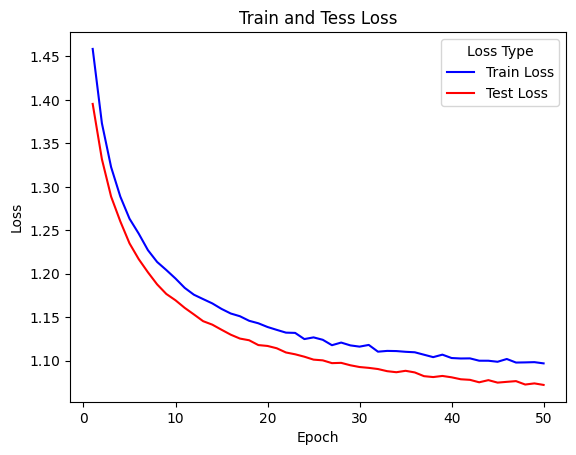

In [ ]:
data = pd.DataFrame({
    'Epoch': range(1, len(test_loss_list) + 1),
    'Train Loss': train_loss_list,
    'Test Loss': test_loss_list
})

data_long = data.melt('Epoch', var_name='Loss Type', value_name='Loss')

sns.lineplot(x='Epoch', y='Loss', hue='Loss Type',  palette=['b', 'r'], data=data_long)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Tess Loss')
plt.legend(title='Loss Type')
plt.show()

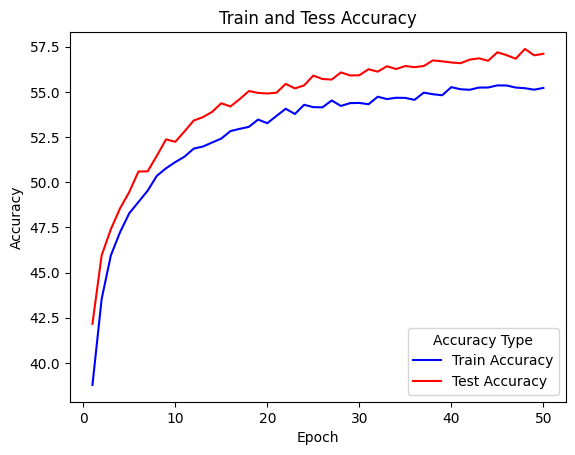

In [ ]:
data = pd.DataFrame({
    'Epoch': range(1, len(test_loss_list) + 1),
    'Train Accuracy': train_acc_list,
    'Test Accuracy': test_acc_list
})

data_long = data.melt('Epoch', var_name='Accuracy Type', value_name='Accuracy')

sns.lineplot(x='Epoch', y='Accuracy', hue='Accuracy Type',  palette=['b', 'r'], data=data_long)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Tess Accuracy')
plt.legend(title='Accuracy Type')
plt.show()

/tmp/ipykernel_3951744/1520282135.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Class', y='Count', data=df, palette='cool')


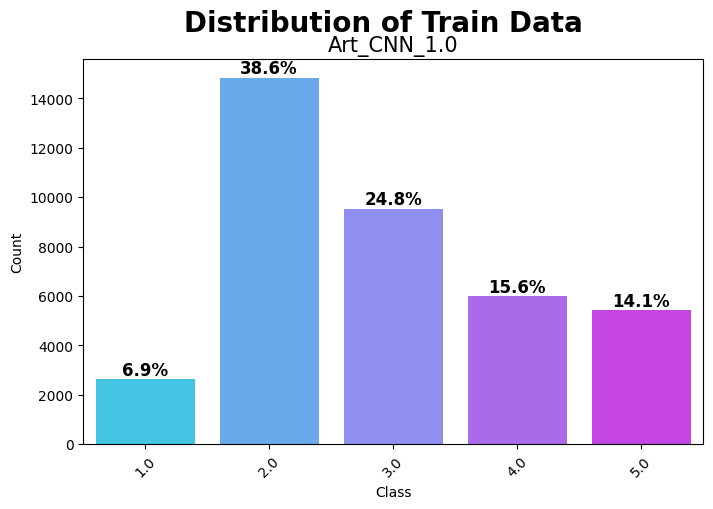

In [ ]:
class_counts = {class_name: 0 for class_name in dataset.classes}

for idx in trainset_pretrained.indices:
    label = dataset.targets[idx] 
    class_counts[dataset.classes[label]] += 1

total_train_samples = sum(class_counts.values())

df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Class', y='Count', data=df, palette='cool')

for p in ax.patches:
    percentage = (p.get_height() / total_train_samples) * 100 
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

plt.suptitle("Distribution of Train Data", fontsize=20, fontweight='bold')
plt.xticks(rotation=45)
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

/tmp/ipykernel_3951744/1275018628.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Class', y='Count', data=df_preds, palette="cool")


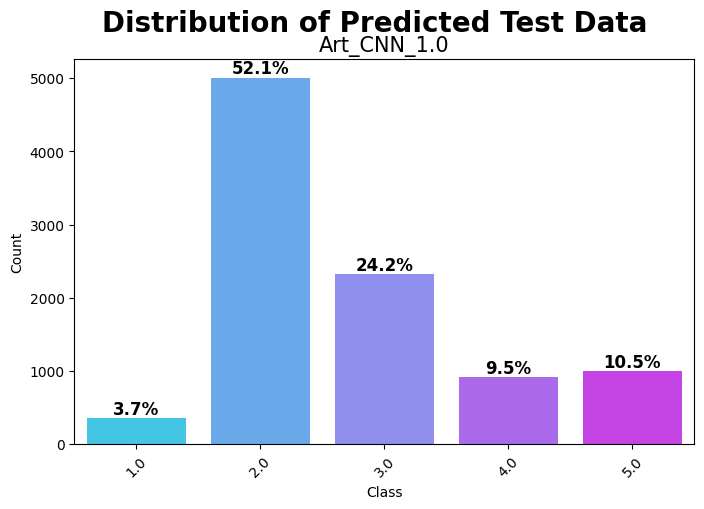

In [ ]:
predicted_counts = {class_name: 0 for class_name in dataset.classes}

for pred in all_preds:
    predicted_counts[dataset.classes[pred]] += 1

total_preds = sum(predicted_counts.values())

df_preds = pd.DataFrame(list(predicted_counts.items()), columns=['Class', 'Count'])

plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Class', y='Count', data=df_preds, palette="cool")

for p in ax.patches:
    percentage = (p.get_height() / total_preds) * 100  
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

plt.suptitle("Distribution of Predicted Test Data", fontsize=20, fontweight='bold')
plt.xticks(rotation=45)
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [ ]:
#fine-tuning

for idx, child in list(enumerate(pretrained_model.base_model.features))[-3:]:
    for param in child.parameters():
        param.requires_grad = True

optimizer_finetune = optim.Adam(filter(lambda p: p.requires_grad, pretrained_model.parameters()), lr=1e-5)

ft_train_loss_list = []
ft_train_acc_list = []
ft_test_loss_list = []
ft_test_acc_list = []

num_epochs_finetune = 5
print("Fine-tuning the pre-trained model (unfreezing last few layers)...")

pretrained_model.train()
for epoch in range(num_epochs_finetune):
    start_time = time.time()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in trainloader_pretrained:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_finetune.zero_grad()
        outputs, _ = pretrained_model(inputs)
        loss = criterion_pretrained(outputs, labels)
        loss.backward()
        optimizer_finetune.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(trainset_pretrained)
    train_accuracy = 100 * correct_train / total_train

    # evaluation
    pretrained_model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in testloader_pretrained:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = pretrained_model(inputs)
            loss = criterion_pretrained(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    epoch_test_loss = test_loss / len(testset_pretrained)
    test_accuracy = 100 * correct_test / total_test
    elapsed_time = time.time() - start_time

    print(f"Epoch [{epoch+1}/{num_epochs_finetune}], "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Test Loss: {epoch_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%, "
          f"Time: {elapsed_time:.2f}s")

    ft_train_loss_list.append(epoch_loss)
    ft_train_acc_list.append(train_accuracy)
    ft_test_loss_list.append(epoch_test_loss)
    ft_test_acc_list.append(test_accuracy)

    pretrained_model.train()

print("Finished fine‑tuning the model.")
torch.save(pretrained_model.state_dict(), 'Models/PreCNN_1.pth')

Fine‑tuning the pre‑trained model (unfreezing last few layers)...
Epoch [1/5], Train Loss: 1.0476, Train Acc: 57.54%, Test Loss: 0.9793, Test Acc: 61.63%, Time: 57.37s
Epoch [2/5], Train Loss: 0.9708, Train Acc: 60.71%, Test Loss: 0.9353, Test Acc: 63.28%, Time: 56.65s
Epoch [3/5], Train Loss: 0.9228, Train Acc: 63.08%, Test Loss: 0.9021, Test Acc: 64.28%, Time: 55.64s
Epoch [4/5], Train Loss: 0.8839, Train Acc: 64.61%, Test Loss: 0.8814, Test Acc: 65.49%, Time: 56.33s
Epoch [5/5], Train Loss: 0.8516, Train Acc: 66.46%, Test Loss: 0.8595, Test Acc: 66.20%, Time: 55.52s
Finished fine‑tuning the model.


RuntimeError: Parent directory Models does not exist.

In [ ]:
pretrained_model.eval()
correct = 0
total = 0
all_embeddings_finetuned = []
all_labels_finetuned = []
all_true_finetuned = []
all_preds_finetuned = []

with torch.no_grad():
    for inputs, labels in testloader_pretrained:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, embeddings = pretrained_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds_finetuned.extend(predicted.cpu().numpy())
        all_true_finetuned.extend(labels.cpu().numpy())
        if len(all_embeddings_finetuned) < 500:
            all_embeddings_finetuned.append(embeddings.cpu())
            all_labels_finetuned.append(labels.cpu())

accuracy_finetuned = 100 * correct / total
print(f"Fine‑tuned model Test Accuracy: {accuracy_finetuned:.2f}%")

all_preds_np = np.array(all_preds_finetuned)
all_true_np = np.array(all_true_finetuned)
    
unique_labels = np.unique(np.concatenate((all_preds_np, all_true_np)))
    
# count correct and incorrect predictions per label
correct_counts = {label: 0 for label in unique_labels}
incorrect_counts = {label: 0 for label in unique_labels}
    
for true, pred in zip(all_true_np, all_preds_np):
    if true == pred:
        correct_counts[true] += 1
    else:
        incorrect_counts[true] += 1

embeddings_finetuned = torch.cat(all_embeddings_finetuned, dim=0)[:500]
labels_finetuned = torch.cat(all_labels_finetuned, dim=0)[:500]

Fine‑tuned model Test Accuracy: 66.20%


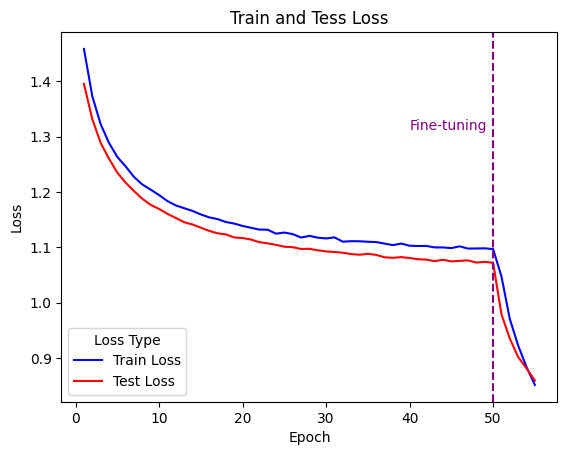

In [ ]:
data = pd.DataFrame({
    'Epoch': range(1, len(ft_test_loss_list) + len(test_loss_list) + 1),
    'Train Loss': train_loss_list + ft_train_loss_list,
    'Test Loss': test_loss_list + ft_test_loss_list 
})

data_long = data.melt('Epoch', var_name='Loss Type', value_name='Loss')

sns.lineplot(x='Epoch', y='Loss', hue='Loss Type',  palette=['b', 'r'], data=data_long)

ft_start_epoch = len(train_loss_list)
plt.axvline(x=ft_start_epoch, color='purple', linestyle='--')
plt.text(ft_start_epoch - 10, max(data_long['Loss']) * 0.9, 'Fine-tuning', color='purple')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Tess Loss')
plt.legend(title='Loss Type')
plt.show()

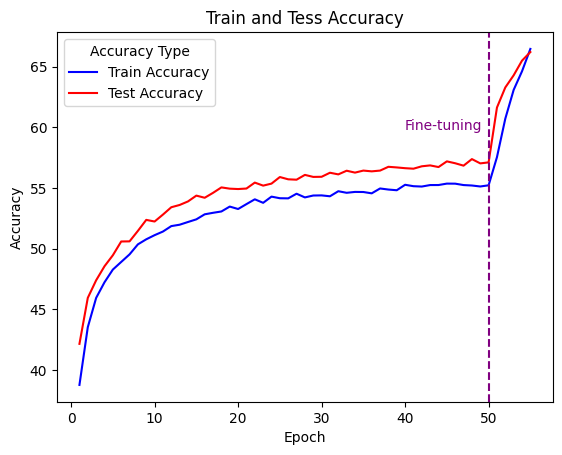

In [ ]:
data = pd.DataFrame({
    'Epoch': range(1, len(ft_test_acc_list) + len(test_acc_list) + 1),
    'Train Accuracy': train_acc_list + ft_train_acc_list,
    'Test Accuracy': test_acc_list + ft_test_acc_list
})

data_long = data.melt('Epoch', var_name='Accuracy Type', value_name='Accuracy')

sns.lineplot(x='Epoch', y='Accuracy', hue='Accuracy Type',  palette=['b', 'r'], data=data_long)

ft_start_epoch = len(train_acc_list)
plt.axvline(x=ft_start_epoch, color='purple', linestyle='--')
plt.text(ft_start_epoch - 10, max(data_long['Accuracy']) * 0.9, 'Fine-tuning', color='purple')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Tess Accuracy')
plt.legend(title='Accuracy Type')
plt.show()

/tmp/ipykernel_3951744/1666247419.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Class', y='Count', data=df_preds, palette="cool")


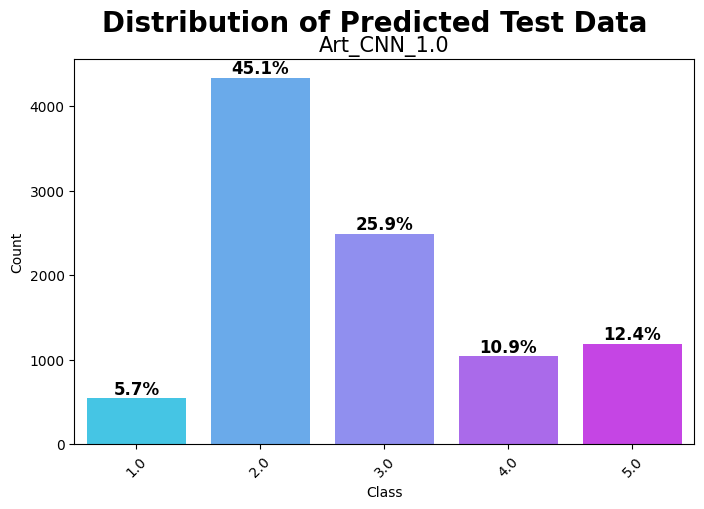

In [ ]:
predicted_counts = {class_name: 0 for class_name in dataset.classes}

for pred in all_preds_finetuned:
    predicted_counts[dataset.classes[pred]] += 1

total_preds = sum(predicted_counts.values())

df_preds = pd.DataFrame(list(predicted_counts.items()), columns=['Class', 'Count'])

plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Class', y='Count', data=df_preds, palette="cool")

for p in ax.patches:
    percentage = (p.get_height() / total_preds) * 100  
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

plt.suptitle("Distribution of Predicted Test Data", fontsize=20, fontweight='bold')
plt.xticks(rotation=45)
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

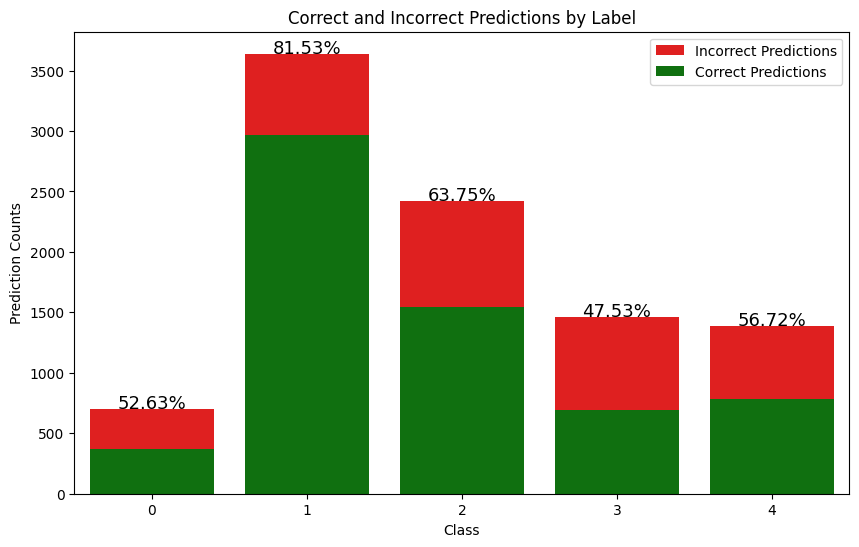

In [ ]:
df = pd.DataFrame({
    "Label": list(correct_counts.keys()),
    "Correct Predictions": list(correct_counts.values()),
    "Incorrect Predictions": list(incorrect_counts.values())
    })
    
plt.figure(figsize=(10, 6))
df["Total Predictions"] = df["Correct Predictions"] + df["Incorrect Predictions"]
    
ax = sns.barplot(data=df, x="Label", y="Total Predictions", color="red", label="Incorrect Predictions")
sns.barplot(data=df, x="Label", y="Correct Predictions", color="green", label="Correct Predictions")
    
for index, row in df.iterrows():
    total = row["Total Predictions"]
    if total > 0:
        percentage = 100 - (row["Incorrect Predictions"] / total) * 100
        plt.text(index, total + 5, f"{percentage:.2f}%", ha='center', fontsize=13)
    
plt.xlabel("Class")
plt.ylabel("Prediction Counts")
plt.title("Correct and Incorrect Predictions by Label")
plt.legend()
    
plt.show()

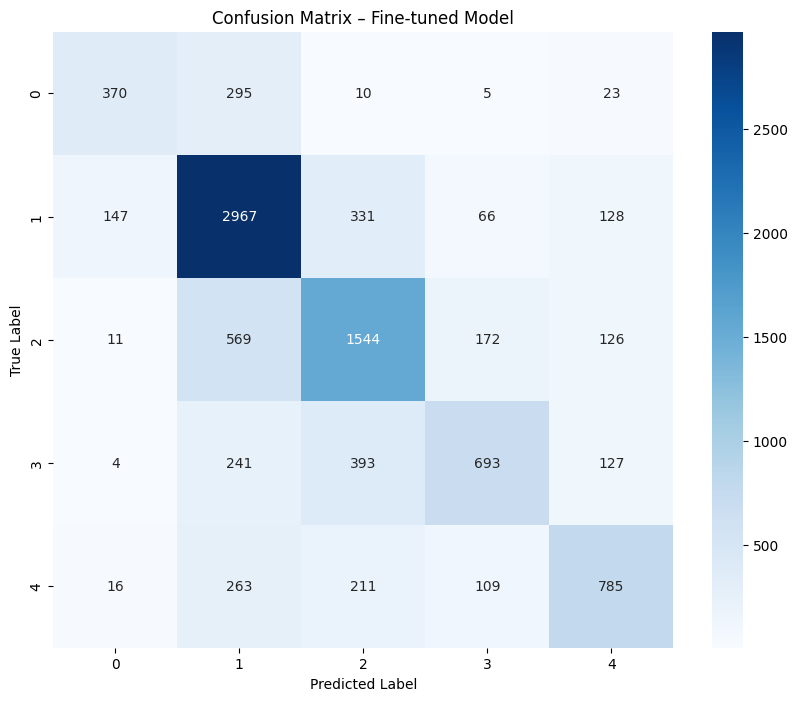

In [ ]:
cm = confusion_matrix(all_true_finetuned, all_preds_finetuned)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – Fine‑tuned Model")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [ ]:
def log_embeddings(writer, embeddings_dict, metadata_dict, global_step=0):
    """
    Logs embeddings to TensorBoard.

    Parameters:
      writer (SummaryWriter): TensorBoard writer.
      embeddings_dict (dict): A dictionary where keys are model names (str)
                              and values are embeddings (torch.Tensor of shape [N, D]).
      metadata_dict (dict): A dictionary where keys are model names (str)
                            and values are lists of metadata strings for each sample.
      global_step (int): Global training step (for TensorBoard).
    """
    for name, emb in embeddings_dict.items():
        writer.add_embedding(emb, metadata=metadata_dict.get(name, None),
                             tag=name, global_step=global_step)
    print("Embeddings logged to TensorBoard.")


In [ ]:
num_samples = 500

embeddings_pretrained_np = embeddings_pretrained_frozen.cpu()  # shape: [num_samples, embedding_dim]
metadata_pretrained = [str(label.item()) for label in labels_pretrained]

embeddings_finetuned_np = embeddings_finetuned.cpu() 
metadata_finetuned = [str(label.item()) for label in labels_finetuned]

embeddings_dict = {
    "pretrained": embeddings_pretrained_np,
    "finetuned": embeddings_finetuned_np
}
metadata_dict = {
    "pretrained": metadata_pretrained,
    "finetuned": metadata_finetuned
}

log_dir = "runs/embeddings_0"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
writer = SummaryWriter(log_dir)

log_embeddings(writer, embeddings_dict, metadata_dict, global_step=0)
writer.close()

print("\nTo visualize the embeddings, run in a terminal:\n\n tensorboard --logdir=runs/embeddings\n")

NameError: name 'embeddings_pretrained_frozen' is not defined